In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from GroupingAlgorithm import *
from utils import get_backend_conectivity, RandomHamiltonian
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

In this notebook we test the VQE class. First we load our IBM account and define the backends. 

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_montreal')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris) # Backend with noise model
NUM_SHOTS = 2**13  # Number of shots for each circuit

We create a Hamiltonian to perform the test.

In [3]:
# qubit_op, init_state = LiH(initial_state=True)
# num_qubits = qubit_op.num_qubits

In [4]:
num_qubits = 2
qubit_op = RandomHamiltonian( num_qubits, 6 )
init_state = QuantumCircuit(num_qubits)
print( qubit_op )

SummedOp([
  II,
  YY,
  IZ,
  XZ,
  YY,
  ZZ
])


We calculate the minimum energy of the Hamiltonian by a classical method.

In [5]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
result_exact.eigenvalue 

(-2.6502815398728843+3.142559095116735e-17j)

We will employ a Hardware efficient variation form.

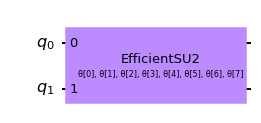

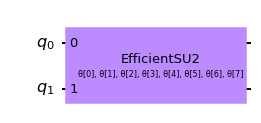

In [6]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

We define a callback function, to have the behavior of the algorithm by iterations.

In [7]:
def callback( evals, params, energy, extra  ):  
    display("{}, {}".format(evals,energy))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []
energies    = [] 

We select SPSA with 100 iterations as classical optimizer.

In [8]:
optimizer = SPSA( maxiter=100, last_avg=1 )

Initial parameters for the optimization

In [9]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

In [10]:
result_exact.eigenvalue 

(-2.6502815398728843+3.142559095116735e-17j)

VQE with entangled grouping

In [11]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

C:\Users\lucia\miniconda3\lib\site-packages\qiskit\algorithms\variational_algorithm.py:88: DeprecationWarning: 
The VariationalAlgorithm is reduced to an interface. Thus, the
quantum_instance property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
  self.quantum_instance = quantum_instance


-2.65234375


VQE with TPB grouping

In [12]:
solver = VQE( ansatz, optimizer, pars, grouping = 'TPB' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.66015625


VQE with entangled grouping and the connectivity of ibmq_paris

In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_paris )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.587890625


Testing callback function

In [14]:
parameters  = []
evaluations = []
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.705078125


Testing simulation with noise model

In [15]:
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=backend_noise )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.18359375


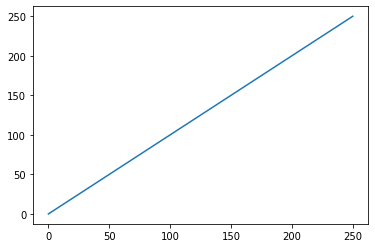

In [16]:
plt.plot( evaluations )

Testing quantum instance

In [17]:
qi = QuantumInstance( backend_sim, shots = NUM_SHOTS )
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=100, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', quantum_instance=qi )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-2.64501953125


In [18]:
print(results)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 200,
    'eigenstate': array([ 0.13815179-0.147923j  ,  0.58268225-0.5048894j ,
       -0.37558795+0.32595926j,  0.23988019-0.24442321j]),
    'eigenvalue': -2.64501953125,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 0.3417334131118239,
                              ParameterVectorElement(θ[6]): -0.6145575836948008,
                              ParameterVectorElement(θ[4]): 0.20985441002527352,
                              ParameterVectorElement(θ[2]): 0.8056785477267682,
                              ParameterVectorElement(θ[0]): 2.011226604343176,
                              ParameterVectorElement(θ[3]): 1.4468125152178986,
                              ParameterVectorElement(θ[5]): -2.2029927325361793,
                              ParameterVectorElement(θ[1]): 0.41168351797260194},
    'optimal_point': array([ 2.0112266 ,  0.41168352,  0.80567855,  1.44681252,  0.20985441,
       -2.20299273, -0.61

Testing another function of the VQE class

In [19]:
solver.ansatz

In [20]:
solver.cleanup_parameterized_circuits

<bound method VariationalAlgorithm.cleanup_parameterized_circuits of <VQE.VQE object at 0x000001D1BB597460>>

In [21]:
solver.construct_expectation( pars, qubit_op )[0].draw()

┌────────────────────────────────────────────────────────┐     ┌───┐»
q56816_0: ┤0                                                       ├──■──┤ H ├»
          │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │┌─┴─┐└┬─┬┘»
q56816_1: ┤1                                                       ├┤ X ├─┤M├─»
          └────────────────────────────────────────────────────────┘└───┘ └╥┘ »
   c13: 2/═════════════════════════════════════════════════════════════════╩══»
                                                                           1  »
«          ┌─┐
«q56816_0: ┤M├
«          └╥┘
«q56816_1: ─╫─
«           ║ 
«   c13: 2/═╩═
«           0

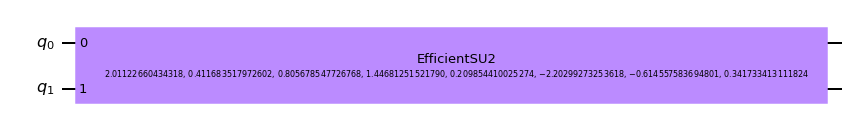

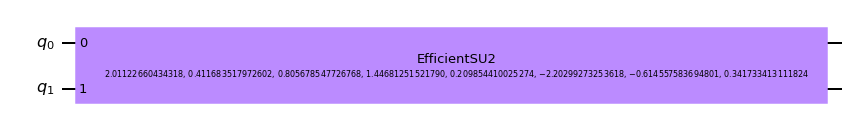

In [22]:
solver.get_optimal_circuit().draw(output='mpl')

In [23]:
solver.get_optimal_cost()

-2.64501953125

In [24]:
solver.get_optimal_vector()

array([ 0.13815179-0.147923j  ,  0.58268225-0.5048894j ,
       -0.37558795+0.32595926j,  0.23988019-0.24442321j])

In [25]:
# solver.get_prob_vector_for_params()

In [26]:
# solver.get_probabilities_for_counts()

In [27]:
solver.initial_point

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

In [28]:
solver.optimal_params

array([ 2.0112266 ,  0.41168352,  0.80567855,  1.44681252,  0.20985441,
       -2.20299273, -0.61455758,  0.34173341])

In [29]:
solver.optimizer

In [30]:
solver.quantum_instance

In [31]:
solver.supports_aux_operators()

False

In [32]:
print( solver.print_settings() )


==================== Setting of VQE ============================
Algorithm: VQE
-- ansatz_params: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])]
-- ansatz:      ┌────────────────────────────────────────────────────────┐
q_0: ┤0                                                       ├
     │  EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                       ├
     └────────────────────────────────────────────────────────┘
-- quantum_instance: 
Qiskit Terra version: 0.18.1
Backend: 'aer_simulator_statevector (None)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu1', 'mcu2', 'm

In [33]:
import qiskit.tools.jupyter
%qiskit_version_table

C:\Users\lucia\miniconda3\lib\site-packages\qiskit\aqua\__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
